# Libraries

In [3]:
import time
import math
import os
from collections import Counter

# Data Analysis
import numpy as np
import pandas as pd
import requests
import bs4
from bs4 import BeautifulSoup

# Visualation
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Machine learning
import sklearn
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score

 # KNN
from sklearn.neighbors import KNeighborsClassifier


from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import make_scorer

# Supervised Learning
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression ,LogisticRegressionCV

# Naive
from sklearn.naive_bayes import GaussianNB

#decision_tree

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Crawllers and Scraping Funcs

In [52]:
# Function that sent request and return soup object if response 200

def load_soup_object(url):
    response = requests.get(url, headers = {"user-agent": "Mozilla/5.0 (X11; Linux x86_64; rv:83.0) Gecko/20100101 Firefox/83.0"})
    if(response.status_code != 200):
        print("Error,can't get this url", response.status_code,"\n")
        exit(1)
    soup = BeautifulSoup(response.content,'html.parser')
    return soup


In [53]:
# From the main page we crawl to the schedule of euroleague
# And return soup object of the relevant page

def get_schedules_object(soup):
    euro_link = soup.find_all('a', {'title':"Schedule"})
    
    for link in euro_link:
        if 'euro' in link['href']:
            soup_sch = load_soup_object(url + link['href'])
            
    return soup_sch


In [54]:
# From the soup object that contain the schedules we extract the year list urls

def years_list_schedule(soup_sch):
    years_list = []
    years =  soup_sch.find('div', class_='card card-body')
    
    for year in years.find_all('a'):
        years_list.append(url + year['href'])
        
    return years_list


In [55]:
# From  each year extract all the pages
# Schedules is a soup object of the first page of evrey year
def pages_list(schedules):
    lst = []
    pages = schedules.find_all('a',class_='pagination-link')
    flag = 1
    
    for page in pages:
        if flag != 1:
            lst.append(url + page['href'])
        flag+=1
    flag =1
    
    return lst

In [56]:
# Scraping the tables from each page into dataframe

def scrape_page(df,page):
    
    for table in page:
        df = pd.concat([df,table])
        
    return df

### proballers web 

In [ ]:
# Web url
BASE = 'https://www.proballers.com'
url = BASE

# Loading the main page
soup = load_soup_object(url)

# Pass to the schedules page in the web
soup_sch = get_schedules_object(soup)

# Get the url's of every year schedule
years_list = years_list_schedule(soup_sch)

# Creat data frame
df = pd.DataFrame()

# List of dataframes from every year
list_of_df = {}

# The years we want
years = [x for x in range(2021,2000,-1)]

In [ ]:
# Crawl every year and scrape the schedule from all the pages

for year,i in zip(years_list,years):
    print("scrape\n",year)
    time.sleep(10)
    # Read_html to get the all tables from the page
    page = pd.read_html(year)
    # Load_soup object to crawl over the pages
    page_soup = load_soup_object(year)
    
    # Scrape the page- concat all the tables
    df = scrape_page(df,page)
    
    # list of the urls of the pages
    page_list = pages_list(page_soup)
    
    # Checking for more pages,if there is then crawl and scrape them
    for pg in page_list:
        print("scrape\n",pg)
        time.sleep(10)
        page = pd.read_html(pg)
        df = scrape_page(df,page)
        
    # df is a full year schedule, now list_of_df will contain every year
    list_of_df[i] = df
    df = df[0:0]
    print("Successful scrape",i,"\n")
    

##### Save

In [ ]:
# Save to csv
# Key is the year and val is the dataframe of the year
# Save the dataframe to csv , format will change the year in the name
for key, val in list_of_df.items():
    val.to_csv(r'C:\Users\or meyuchas\JupyterProject\Data_Sience_project\data\Schedule_{}.csv'.format(str(key)), index = False)

##### Load

In [5]:
# Upload the list_of_df
years = [x for x in range(2021,2000,-1)]
list_of_df = {}
for key in years:
    list_of_df[key]= pd.read_csv(r'C:\Users\or meyuchas\JupyterProject\Data_Sience_project\data\Schedule_{}.csv'.format(str(key)))

# Clean the data & Preper the data

In [58]:
# Reset index

for index in years:
    list_of_df[index] = list_of_df[index].reset_index(drop=True)
    

In [59]:
# Remove duplicates rows from each year

count = 0
for year in years:
    list_of_df[year] = list_of_df[year].drop_duplicates()
    count += len(list_of_df[year])-len(list_of_df[year].drop_duplicates())
print("Droped",count,"of duplicated rows")


Droped 0 of duplicated rows


In [60]:
# Fix the date format in every dataframe

for year in years:
    list_of_df[year]['Day']= pd.to_datetime(list_of_df[year]['Day'], format='%b/%d/%Y',infer_datetime_format=True)

In [92]:
for year in years:
    list_of_df[year] = list_of_df[year].sort_values(by ='Day', ascending = 0).reset_index(drop=True)


##### after i scraped every schedule of every year to "list_of_df" i did few steps:
###### 1. fix the score column that given like that 'X - Y' , and as str, to 2 columns:
######     one for the home team and one for the away team, and save the score as float.
###### 2. creat new column for the winner team in the game


In [62]:
# The score column is a string of the match
# Split the 'Score' column into two arrays
# Creat new two column with score for each team
# Convert the score to integers

def score(df):
    list_1 = df['Score'].str.split('-')
    team_A_score = []
    team_B_score = []
    
    for index in list_1:
        if type(index) != float:
            team_A_score.append(int(index[0]))
            team_B_score.append(int(index[1]))
        else:
            team_A_score.append(0)
            team_B_score.append(0)
        
    df['team_A_score'] = team_A_score
    df['team_B_score'] = team_B_score
    df = df.drop(['Score'], axis=1)
    return df


In [63]:
# Creat new column of the winner team

def winner(df):
    winner_team = []
    row = 0
    
    for i,j in zip(df['team_A_score'],df['team_B_score']):
        if i > j:
            winner_team.append(df['Team 1'][row])
        elif j > i:
            winner_team.append(df['Team 2'][row])
        else:
            winner_team.append('None')
        row += 1
    df['winner_team']=winner_team
    
    return df


In [64]:
# Combain the functions 'score' and 'winner' and implementation
for index in years:
    df = list_of_df[index]
    df = score(df)
    df = winner(df)
    list_of_df[index] = df

In [10]:
list_of_df[2021][:8]

,League,Day,Team 1,Team 2,Score
0,Euroleague,"Oct 1, 2020",Anadolu Efes,Zenit St. Petersburg,69 - 73
1,Euroleague,"Oct 1, 2020",Olympiacos,Zalgiris,67 - 68
2,Euroleague,"Oct 1, 2020",Maccabi Playtika Tel Aviv,Alba Berlin,80 - 73
3,Euroleague,"Oct 1, 2020",F.C. Barcelona,CSKA Moscow,76 - 66
4,Euroleague,"Oct 1, 2020",Valencia,LDLC ASVEL,65 - 63
5,Euroleague,"Oct 2, 2020",Fenerbahce,Crvena zvezda mts,77 - 63
6,Euroleague,"Oct 2, 2020",Khimki Moscow Region,Panathinaikos,76 - 78
7,Euroleague,"Oct 2, 2020",FC Bayern München,AX Armani Exchange Milano,79 - 81


##### Last 10 games record calculate for every team


In [65]:
# Get Team name and return DataFrame for only this team for specific season

def split_team(list_of_df, year , team_name):
    df_team = list_of_df[year][list_of_df[year]['Team 1'].str.contains(team_name) | list_of_df[year]['Team 2'].str.contains(team_name)]
    df_team = df_team.reset_index(drop=True)
    return df_team
    

In [66]:
#last 10 games of team1 - get 'dataframe', team name , year of the game, date of the game as a string like that 'year-month-day'
# calling 'split_team' function

def team1_last_ten_games(list_of_df,team12,year,date):
    df_team12 = pd.DataFrame()
    rng = []
    if (year < 2001) | (year > 2021):
        print("Error year\n")
        return False
    elif year == 2001:
        rng.append(year) 
    elif year == 2002:
        rng.append(2002)
        rng.append(2001)
    else:
        for i in range(year,year - 3, -1):
            rng.append(i)
    for j in rng:
        te = split_team(list_of_df,j , team12)
        df_team12 = pd.concat([df_team12,te])
    df_team12 = df_team12.sort_values(by ='Day', ascending = 0).reset_index(drop=True)
    df_team12 = df_team12[(df_team12['Day'] < date)].iloc[:10].reset_index(drop=True)
    
    return df_team12


In [67]:
# count number of winning game

def count_wins(df,team):
    count = 0
    for home,away,hp,ap in zip(df['Team 1'],df['Team 2'],df['team_A_score'],df['team_B_score']):
        if home == team:
            if hp > ap:
                count+=1
        else:
            if ap > hp:
                count+=1
    return count


In [68]:
# count number of losing game

def count_lose(df,team):
    count = 0
    for home,away,hp,ap in zip(df['Team 1'],df['Team 2'],df['team_A_score'],df['team_B_score']):
        if home == team:
            if hp < ap:
                count+=1
        else:
            if ap < hp:
                count+=1
    return count


In [69]:
# count number of positive points

def count_positive_when_win(df,team):
    count = 0
    for home,away,hp,ap in zip(df['Team 1'],df['Team 2'],df['team_A_score'],df['team_B_score']):
        if home == team:
            if hp > ap:
                count+=hp
        else:
            if ap > hp:
                count+=ap
    return count

def count_positive_when_lose(df,team):
    count = 0
    for home,away,hp,ap in zip(df['Team 1'],df['Team 2'],df['team_A_score'],df['team_B_score']):
        if home == team:
            if hp < ap:
                count+=hp
        else:
            if ap < hp:
                count+=ap
    return count


In [70]:
# count number of negative points

def count_negative_when_win(df,team):
    count = 0
    for home,away,hp,ap in zip(df['Team 1'],df['Team 2'],df['team_A_score'],df['team_B_score']):
        if home == team:
            if hp > ap:
                count+=ap
        else:
            if ap > hp:
                count+=hp
    return count

def count_negative_when_lose(df,team):
    count = 0
    for home,away,hp,ap in zip(df['Team 1'],df['Team 2'],df['team_A_score'],df['team_B_score']):
        if home == team:
            if hp < ap:
                count+=ap
        else:
            if ap < hp:
                count+=hp
    return count

In [71]:

def last_ten_static(df,team):
    data = {'Tgames':[],'Wgames':[],'Lgames':[],'W%':[],'L%':[],
            'Ppoints':[],'Npoints':[],'PPPWG':[],'NPPWG':[],'PPPLG':[],'NPPLG':[],
            'DiffT':[],'DiffW':[],'DiffL':[],'Ratio':[]}
    pppwg = count_positive_when_win(df,team)
    ppplg = count_positive_when_lose(df,team)
    nppwg = count_negative_when_win(df,team)
    npplg = count_negative_when_lose(df,team)
    np =  nppwg + npplg
    pp =  pppwg + ppplg
    w = count_wins(df,team)
    l = count_lose(df,team)
    if (w==0) | (l==0):
        for i in data.keys():
            data[i].append(0)
    else:
        data['Tgames'].append(w+l)
        data['Wgames'].append(w)
        data['Lgames'].append(l)
        data['W%'].append(round((w/(w+l))*100,2))
        data['L%'].append(round((l/(w+l))*100,2))
        data['Ppoints'].append(pp)
        data['Npoints'].append(np)
        data['PPPWG'].append(round(pppwg/w,2))
        data['NPPWG'].append(round(nppwg/w,2))
        data['PPPLG'].append(round(ppplg/l,2))
        data['NPPLG'].append(round(npplg/l,2))
        data['DiffT'].append(pp-np)
        data['DiffW'].append(round(pppwg/w,2)-round(nppwg/w,2))
        data['DiffL'].append(round(ppplg/l,2)-round(npplg/l,2))
        data['Ratio'].append(pp/np)
    final = pd.DataFrame(data)
    return final

In [72]:
# Get df to calculate and list_of_df to search the last 10 games
# Take row, get the teams names and the date and search for last 10 games in max last 3 years
# Calculate statistics of the last 10 for each team and attach it to the row and return

def preper_final_table(df, list_of_df):
    final_df_team1 = pd.DataFrame()
    final_df_team2 = pd.DataFrame()
    # take every date and teams names
    for day, team1, team2 in zip(df['Day'],df['Team 1'],df['Team 2']):
        date = str(day)[:10]
        year = int(date[:4])

        # take the last ten games of team 1, make statistics from them and connect to dataframe
        df_team1 = team1_last_ten_games(list_of_df,team1,year,date)
        df_team1 = last_ten_static(df_team1,team1)
        final_df_team1 = pd.concat([final_df_team1,df_team1])
        df_team1 = df_team1[0:0]

        # take the last ten games of team 2, make statistics from them and connect to dataframe
        df_team2 = team1_last_ten_games(list_of_df,team2,year,date)
        df_team2 = last_ten_static(df_team2,team2)
        final_df_team2 = pd.concat([final_df_team2,df_team2])
        df_team2 = df_team2[0:0]

    final_df_team1.rename(columns={'Tgames':'Tgames1','Wgames':'Wgames1','Lgames':'Lgames1',
                                       'W%':'W%1','L%':'L%1','Ppoints':'Ppoints1','Npoints':'Npoints1',
                                   'PPPWG':'PPPWG1','NPPWG':'NPPWG1','PPPLG':'PPPLG1',
                                       'NPPLG':'NPPLG1','DiffT':'DiffT1','DiffW':'DiffW1',
                                       'DiffL':'DiffL1','Ratio':'Ratio1'}, inplace=True)
    final_df_team2.rename(columns={'Tgames':'Tgames2','Wgames':'Wgames2','Lgames':'Lgames2',
                                       'W%':'W%2','L%':'L%2','Ppoints':'Ppoints2','Npoints':'Npoints2',
                                   'PPPWG':'PPPWG2','NPPWG':'NPPWG2','PPPLG':'PPPLG2',
                                       'NPPLG':'NPPLG2','DiffT':'DiffT2','DiffW':'DiffW2',
                                       'DiffL':'DiffL2','Ratio':'Ratio2'}, inplace=True)

    final_df_team1 = final_df_team1.reset_index(drop=True)
    final_df_team2 = final_df_team2.reset_index(drop=True)
    pd2 = pd.concat([final_df_team1,final_df_team2],axis=1)
    pd2 = pd2.reset_index(drop=True)
    df = pd.concat([df,pd2],axis=1)
    return df
        

In [73]:
# preper_final_table is the function that connect between all the function above her from the last 10 games header
# the function will get the list of df that contain all the data and new list to insert the new data that preperd

df_proper = pd.DataFrame()
for year in range(2021,2001,-1):
    temp = preper_final_table(list_of_df[year], list_of_df)
    df_proper = pd.concat([df_proper, temp])
    temp = temp[0:0]

#df_proper is the full dataframe that we sent to machine


In [74]:
# Check if all the data will transform

counter = 0
for year in range(2021,2001,-1):
    counter += list_of_df[year].shape[0]
if counter == df_proper.shape[0]:
    print("All the data tranform successfully\n")
else:
    print("Not all the data transform\n")
    

All the data tranform successfully



### *new data explanation

##### Tgames = total games the team played
##### Wgames = sum of winning games
##### Lgames = sum of lossing games

##### W% = winning precent
##### L% = lossing precent

##### Ppoints = positive points for the team
##### Npoints = negative points for the team

##### PPPWG = Positive Points Per Game of winning
##### NPPWG = Negative Points Per Game of winning
##### PPPLG = Positive Points Per Game of lossing
##### NPPLG = Negative Points Per Game of lossing

##### DiffT = difference between the positive point to negative in total games
##### DiffW = difference between the positive point to negative when the team win
##### DiffL = difference between the positive point to negative  when the team lose

##### Ratio = the ratio between the negative and positive points - more then 1 is good, 1 is even, less then 1 is not good

##### Save point 2

In [75]:
df_proper.to_csv(r'C:\Users\or meyuchas\JupyterProject\Data_Sience_project\data\df_proper.csv', index = False)

##### Load point 2

In [7]:
df_proper = pd.read_csv(r'C:\Users\or meyuchas\JupyterProject\Data_Sience_project\data\df_proper.csv')

# Visualation

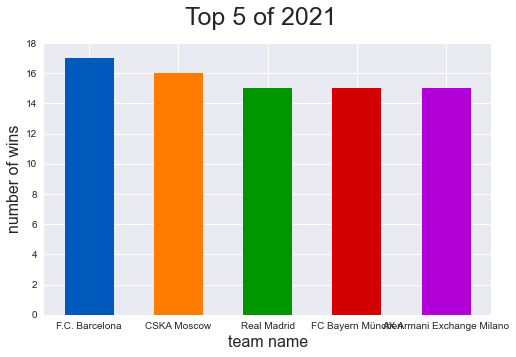

In [959]:
# Ditails: 
# Top 5 teams of 2021 by winning from the begin of the season

def top_5(df, col_name):
    pt = df[df[col_name] != 'None']
    plot_t = pt[col_name].value_counts()[:5]
    colors = [(0,0.349,0.737),(1,0.486,0),(0,0.588,0),(0.823,0,0),(0.698,0,0.85)]
    fig = plt.figure(figsize=(8,5))
    fig.suptitle('Top 5 of 2021', fontsize=25)
    plt.style.use('seaborn')
    plt.bar(plot_t.index,plot_t.values,width=0.55, color=colors)
    plt.bar(plot_t.index,plot_t.values,width=0.55, color=colors)
    plt.xlabel('team name', fontsize=16,)
    plt.ylabel('number of wins', fontsize=16,rotation=90)
    plt.ylim([0,18])
    #fig.savefig(r'C:\Users\or meyuchas\JupyterProject\PersonalProjects\Perfect_pro\images\top_5_of_2021.jpg')
    plt.show()
    
top_5(list_of_df[2021], 'winner_team')

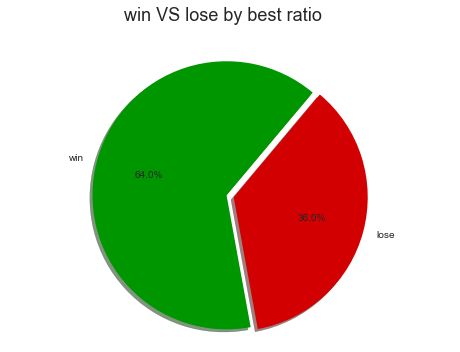

In [955]:
# Ditails:
# I have the ratio between the negative and positive points from the last ten games for each team,
# i want to check if the team that came to the game with better ratio, is the team that win.
def check_contant_between_ratio_and_wins(df_proper):
    ratio_plot = df_proper[(df_proper.Tgames1 == 10) & (df_proper.Tgames2 == 10) & (df_proper.winner_team != 'None')]
    win_check = ratio_plot.loc[((ratio_plot['Ratio1']>ratio_plot['Ratio2']) & (ratio_plot['Team 1']==ratio_plot['winner_team']))
                      | ((ratio_plot['Ratio1'] < ratio_plot['Ratio2']) & (ratio_plot['Team 2']==ratio_plot['winner_team']))]
    wins = round((win_check.shape[0] / ratio_plot.shape[0]) * 100 , 2)
    lose = 100 - wins
    fig1, ax1 = plt.subplots()
    ax1.pie([wins , lose],explode=(0.03,0.025),colors=[(0,0.588,0),(0.823,0,0)], labels=['win','lose'], autopct='%1.1f%%',
        shadow=True, startangle=50)
    ax1.axis('equal')
    fig1.suptitle('win VS lose by best ratio', fontsize=18)
    #fig1.savefig(r'C:\Users\or meyuchas\JupyterProject\PersonalProjects\Perfect_pro\images\percentage_wins_by_ratio.jpg')
    plt.show()
    
check_contant_between_ratio_and_wins(df_proper)

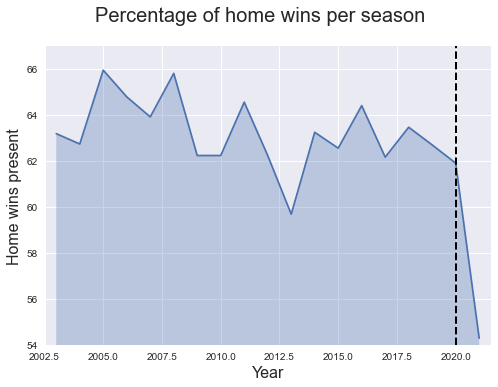

In [956]:
# Ditails: 
# check if there is advantage to home team,
# and if there was, checking if was a change on the advantage that starts on 2020,
# since from that moment the games were played without fans. (Note: I'm not checking if no fans is the reason.
# only check if there is change in the last year ,and  i'm just guessing that is the reason)


def check_corona_sesson(list_of_df):
    p =[]
    for k in range(2021,2002,-1):
        d = list_of_df[k]
        c = 0
        non = 0
        for i in d['winner_team']:
            if i == 'None':
                non += 1

        for i,j in zip(d['Team 1'],d['winner_team']):
            if i == j:
                c += 1

        a = list_of_df[k].shape[0] - non
        r = round((c/a) * 100,2)
        p.append(r)
        
    fig = plt.figure()
    plt.plot([x for x in range(2021,2002,-1)],p)
    plt.axvline(x=2020, label='line at x = 2020', c='k', ls='--', lw=2)
    #plt.hlines(y=62,xmin=2002.5,xmax=2022, label='line at y = 62', color='k', ls='--', lw=2)
    fig.suptitle('Percentage of home wins per season', fontsize=20)
    plt.xlabel('Year', fontsize=16,)
    plt.ylabel('Home wins present', fontsize=16,rotation=90)
    plt.xlim([2002.5 ,2021.5]) 
    plt.ylim([54,67])
    plt.fill_between([x for x in range(2021,2002,-1)],p,alpha=0.30)
    #fig.savefig(r'C:\Users\or meyuchas\JupyterProject\PersonalProjects\Perfect_pro\images\percentage_home_wins.jpg')
    plt.show()
    
check_corona_sesson(list_of_df)

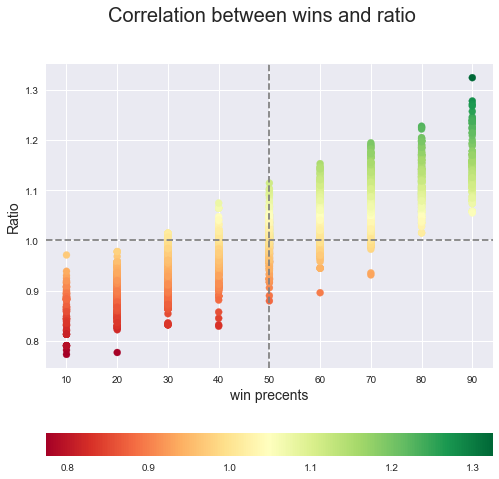

In [31]:
# Ditails: 
# checking correlation between wins precents and ratio

def correlation(df_proper):
    plot_sns = df_proper[(df_proper.Tgames1 == 10) & (df_proper.Tgames2 == 10) & (df_proper.winner_team != 'None')]
    fig2 = plt.figure(figsize=(8,8))

    plt.axvline(50, c=(0.5,0.5,0.5), ls='--')
    plt.axhline(1, c=(0.5,0.5,0.5), ls='--')
    plt.style.use('seaborn')
    plt.scatter(plot_sns['W%1'],plot_sns['Ratio1'],c=plot_sns['Ratio1'],cmap='RdYlGn')
    fig2.suptitle('Correlation between wins and ratio', fontsize=20)
    plt.xlabel('win precents', fontsize=14)
    plt.ylabel('Ratio', fontsize=14,rotation=90)
    plt.colorbar(orientation='horizontal')
    #fig2.savefig(r'C:\Users\or meyuchas\JupyterProject\PersonalProjects\Perfect_pro\images\corellation.jpg')

correlation(df_proper)

##### Search corolation

In [779]:
# Ditails: 
# checking for correlation 

def get_highly_correlated_cols(df):
    corr = df.corr()
    arr_index =[]
    arr_value =[]
    size = len(corr)
    for col in range(size):
        for row in range(col+1,size):
            if (corr.iloc[col,row]>0.7) & (corr.iloc[col,row]<0.9):
                arr_index.append((col,row))
                arr_value.append(corr.iloc[col,row])
    return(arr_value,arr_index)

In [780]:
cols_for_correlations = ['Wgames1', 'Lgames1', 'W%1', 'L%1',
                           'Ppoints1', 'Npoints1', 'PPPWG1', 'NPPWG1', 'PPPLG1', 'NPPLG1',
                               'DiffT1', 'DiffW1', 'DiffL1', 'Ratio1', 'Wgames2', 'Lgames2',
                           'W%2', 'L%2', 'Ppoints2', 'Npoints2', 'PPPWG2', 'NPPWG2', 'PPPLG2',
                                   'NPPLG2', 'DiffT2', 'DiffW2', 'DiffL2', 'Ratio2']


In [781]:
correlations, tuple_arr = get_highly_correlated_cols(df_proper[cols_for_correlations])
indx_sort = np.argsort(correlations)

In [783]:
data = {'Col_1':[], 'Col_2':[],'Corr':[]}
for n_correlation in indx_sort:
    col_lt, col_rt = tuple_arr[n_correlation]
    col_name_lt, col_name_rt = cols_for_correlations[col_lt], cols_for_correlations[col_rt]
    data['Col_1'].append(col_name_lt)
    data['Col_2'].append(col_name_rt)
    data['Corr'].append(correlations[n_correlation])

df_corr = pd.DataFrame(data, columns = ['Col_1', 'Col_2','Corr'])     

In [863]:
df_corr

,Col_1,Col_2,Corr
0,W%1,DiffT1,0.700461
1,Wgames2,DiffT2,0.703396
2,W%2,DiffT2,0.704604
3,DiffW2,Ratio2,0.707254
4,DiffW1,Ratio1,0.710806
5,Wgames1,Ratio1,0.764821
6,Wgames2,Ratio2,0.765001
7,W%1,Ratio1,0.768986
8,W%2,Ratio2,0.770060


# Machine Learning

In [12]:
# Drop rows without last 10 games statistics or not played

ML = df_proper[(df_proper.Tgames1 == 10) & (df_proper.Tgames2 == 10) & (df_proper.winner_team != 'None')]

print(df_proper.shape[0] - ML.shape[0],"rows are droped\n")


930 rows are droped



In [13]:
# Creat column of binary value by who win- home team = 1, away team = 0

def creat_binary_column(ML):
    lst = []
    for i,j in zip(ML['Team 1'], ML['winner_team']):
        if i == j:
            lst.append(1)
        else:
            lst.append(0)
    #ML['winner_team_binary'] = lst.values
    #return ML
    return lst


lst = creat_binary_column(ML)
ML.insert(loc=0, column='winner_team_binary', value=lst)

##### Split to train and test

In [16]:
def split_train_and_test(ML):
    good = []
    junk = ['League','Day','Team 1','Team 2','team_A_score','team_B_score','winner_team','winner_team_binary','Tgames1','Tgames2']
    for j in ML.columns:
        if j not in junk:
            good.append(j)
    X = ML[good]
    y = ML['winner_team_binary']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_train_and_test(ML)


In [930]:
# Models

def logistic_regression(X_train, y_train):
    clf = LogisticRegression().fit(X_train, y_train)
    return clf

def KNN(X_train, y_train):
    best_k = find_best_K(X_train, y_train)
    params = {'n_neighbors':best_k}
    clf = KNeighborsClassifier(n_neighbors=params['n_neighbors']).fit(X_train, y_train)
    print("Best K is:",best_k,"\n")
    return clf

def find_best_K(X_train, y_train):
    parameters = {'n_neighbors':[x for x in range(3,20,2)]}
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters, scoring=make_scorer(metrics.accuracy_score, greater_is_better=True))
    clf.fit(X_train, y_train)
    best_K = clf.best_params_['n_neighbors']
    return best_K

def decision_tree(X_train, y_train):
    best_max_depth, best_min_samples_split = find_best_decision_tree_params(X_train, y_train)
    params = {'max_depth':best_max_depth, 'min_samples_split':best_min_samples_split}
    clf = DecisionTreeClassifier(max_depth=params['max_depth'],
                                 min_samples_split=params['min_samples_split']).fit(X_train, y_train)
    print("Best max depth is:",best_max_depth,"\n")
    print("Best min samples split:",best_min_samples_split,"\n")
    return clf    
    
def find_best_decision_tree_params(X_train, y_train):
    parameters = {'max_depth':[2,4,6,8,10], 'min_samples_split':[5,10,15,20]}
    dt = tree.DecisionTreeClassifier()
    clf = GridSearchCV(dt,parameters,scoring=make_scorer(metrics.accuracy_score, greater_is_better=True))
    clf.fit(X_train, y_train)
    best_max_depth = clf.best_params_['max_depth']
    best_min_samples_split = clf.best_params_['min_samples_split']
    return best_max_depth, best_min_samples_split


In [931]:
# Display confusion matrix of each model

def evo_met(y_test , y_pred,name):   
    evo = metrics.confusion_matrix(y_test , y_pred)
    df_confusion = pd.DataFrame(evo , index=['Actual Negative','Actual Positive'],columns=['Predicted Negative','Predicted Positive'])
    print("confusion matrix of",name,"is:\n")
    display(df_confusion)

In [605]:
# Scale the data

scaler = StandardScaler()
X_scale_train = scaler.fit_transform(X_train)
X_scale_test = scaler.transform(X_test)

In [946]:
# Lists

category = ['accuracy','precision','recall','f1_score']
machine = ['logistic_regression','KNN','decision_tree']
train = []
test = []


##### logistic_regression

In [947]:
LR_clf = logistic_regression(X_scale_train, y_train)

In [948]:
LR_y_pred_train = LR_clf.predict(X_scale_train)
train.append(round(metrics.accuracy_score(y_train, LR_y_pred_train), 5))
evo_met(y_train, LR_y_pred_train,'logistic regression train')

confusion matrix of logistic regression train is:



,Predicted Negative,Predicted Positive
Actual Negative,465,691
Actual Positive,292,1593


In [949]:
LR_y_pred_test = LR_clf.predict(X_scale_test)
test.append(round(metrics.accuracy_score(y_test, LR_y_pred_test), 5))
evo_met(y_test, LR_y_pred_test,'logistic regression test')

confusion matrix of logistic regression test is:



,Predicted Negative,Predicted Positive
Actual Negative,111,154
Actual Positive,73,423


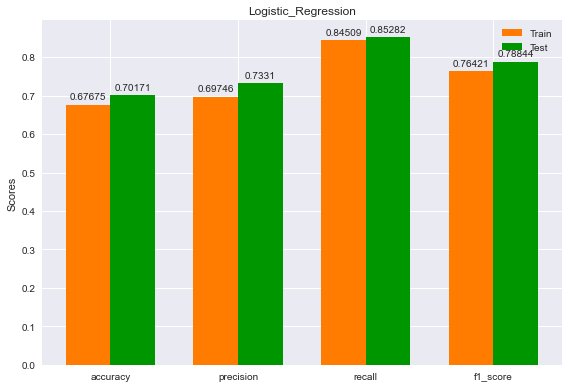

In [935]:
LR_train = []
LR_test = []

# train
LR_train.append(round(metrics.accuracy_score(y_train, LR_y_pred_train), 5))
LR_train.append(round(metrics.precision_score(y_train, LR_y_pred_train), 5))
LR_train.append(round(metrics.recall_score(y_train, LR_y_pred_train), 5))
LR_train.append(round(metrics.f1_score(y_train, LR_y_pred_train), 5))
# test
LR_test.append(round(metrics.accuracy_score(y_test, LR_y_pred_test), 5))
LR_test.append(round(metrics.precision_score(y_test, LR_y_pred_test), 5))
LR_test.append(round(metrics.recall_score(y_test, LR_y_pred_test), 5))
LR_test.append(round(metrics.f1_score(y_test, LR_y_pred_test), 5))
# plot
plotplot(category,LR_train,LR_test,'Logistic_Regression')

##### KNN

In [936]:
knn_clf = KNN(X_scale_train, y_train)

Best K is: 17 



In [950]:
knn_y_pred_train = knn_clf.predict(X_scale_train)
train.append(round(metrics.accuracy_score(y_train, knn_y_pred_train), 5))
evo_met(y_train, knn_y_pred_train,'KNN train')

confusion matrix of KNN train is:



,Predicted Negative,Predicted Positive
Actual Negative,552,604
Actual Positive,308,1577


In [951]:
knn_y_pred_test = knn_clf.predict(X_scale_test)
test.append(round(metrics.accuracy_score(y_test, knn_y_pred_test), 5))
evo_met(y_test, knn_y_pred_test,'KNN test')

confusion matrix of KNN test is:



,Predicted Negative,Predicted Positive
Actual Negative,114,151
Actual Positive,86,410


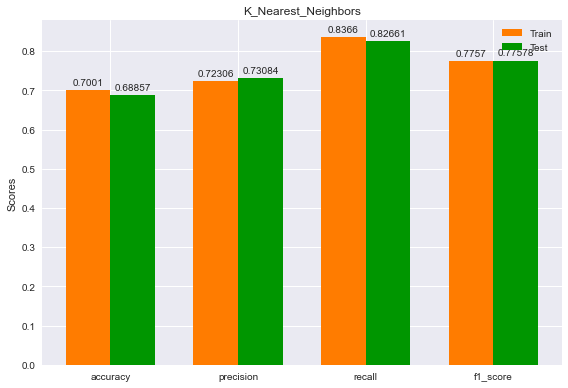

In [939]:
knn_train = []
knn_test = []

# train
knn_train.append(round(metrics.accuracy_score(y_train, knn_y_pred_train), 5))
knn_train.append(round(metrics.precision_score(y_train, knn_y_pred_train), 5))
knn_train.append(round(metrics.recall_score(y_train, knn_y_pred_train), 5))
knn_train.append(round(metrics.f1_score(y_train, knn_y_pred_train), 5))
# test
knn_test.append(round(metrics.accuracy_score(y_test, knn_y_pred_test), 5))
knn_test.append(round(metrics.precision_score(y_test, knn_y_pred_test), 5))
knn_test.append(round(metrics.recall_score(y_test, knn_y_pred_test), 5))
knn_test.append(round(metrics.f1_score(y_test, knn_y_pred_test), 5))
# plot
plotplot(category,knn_train,knn_test,'K_Nearest_Neighbors')

##### decision_tree

In [940]:
DT_clf = decision_tree(X_scale_train, y_train)

Best max depth is: 2 

Best min samples split: 10 



In [952]:
DT_y_pred_train = DT_clf.predict(X_scale_train)
train.append(round(metrics.accuracy_score(y_train, DT_y_pred_train), 5))
evo_met(y_train, DT_y_pred_train,'decision tree train')

confusion matrix of decision tree train is:



,Predicted Negative,Predicted Positive
Actual Negative,396,760
Actual Positive,245,1640


In [953]:
DT_y_pred_test = DT_clf.predict(X_scale_test)
test.append(round(metrics.accuracy_score(y_test, DT_y_pred_test), 5))
evo_met(y_test, DT_y_pred_test,'decision tree test')

confusion matrix of decision tree test is:



,Predicted Negative,Predicted Positive
Actual Negative,84,181
Actual Positive,65,431


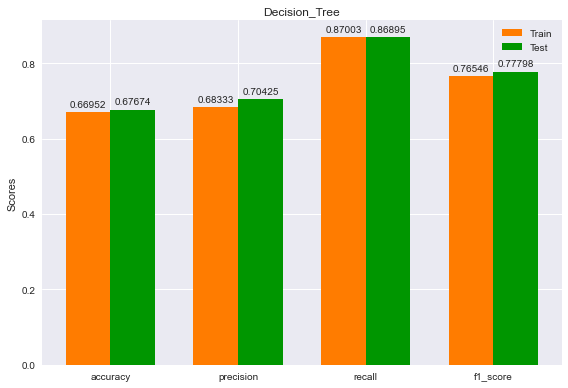

In [943]:
DT_train = []
DT_test = []

# train
DT_train.append(round(metrics.accuracy_score(y_train, DT_y_pred_train), 5))
DT_train.append(round(metrics.precision_score(y_train, DT_y_pred_train), 5))
DT_train.append(round(metrics.recall_score(y_train, DT_y_pred_train), 5))
DT_train.append(round(metrics.f1_score(y_train, DT_y_pred_train), 5))
# test
DT_test.append(round(metrics.accuracy_score(y_test, DT_y_pred_test), 5))
DT_test.append(round(metrics.precision_score(y_test, DT_y_pred_test), 5))
DT_test.append(round(metrics.recall_score(y_test, DT_y_pred_test), 5))
DT_test.append(round(metrics.f1_score(y_test, DT_y_pred_test), 5))
# plot
plotplot(category,DT_train,DT_test,'Decision_Tree')

##### Compare models by accuracy

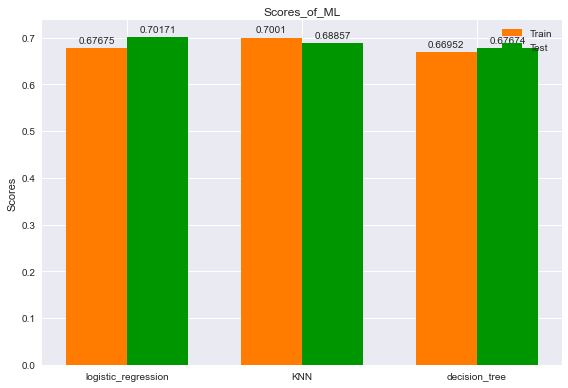

In [960]:
def plotplot(machine,train,test,name):
    x = np.arange(len(machine))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, train, width, label='Train',color=(1,0.486,0))
    rects2 = ax.bar(x + width/2, test, width, label='Test',color=(0,0.588,0))

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title(name)
    ax.set_xticks(x)
    ax.set_xticklabels(machine)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    #fig.savefig(r'C:\Users\or meyuchas\JupyterProject\PersonalProjects\Perfect_pro\images\{}.jpg'.format(name))
    plt.show()
    
plotplot(machine,train,test,'Scores_of_ML')